# Make crops, not war

In [450]:
import sys
sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from src.plots import country_in_war

%matplotlib inline

sns.set_style('whitegrid')

# add time converter for matplotlib visualisation
pd.plotting.register_matplotlib_converters()

In [451]:
prep_data_path = '../pandas_dfs/'

merged_data_file = 'merged_data.csv'
wars_file = 'final_wars_df.csv'
years_per_country_file = 'years_per_country.csv'

merged_crops_data = pd.read_csv(prep_data_path + merged_data_file)
wars_df = pd.read_csv(prep_data_path + wars_file)
years_per_country = pd.read_csv(prep_data_path + years_per_country_file)

First, let us change some names which are different among the dataframes:

In [452]:
merged_crops_data.loc[merged_crops_data['country'] == 'Viet Nam', 'country'] = 'Vietnam'
merged_crops_data.loc[merged_crops_data['country'].str.contains('Syria'), 'country'] = 'Syria'
merged_crops_data.loc[merged_crops_data['country'] == 'Sudan (former)', 'country'] = 'Sudan'
merged_crops_data.loc[merged_crops_data['country'] == 'Russian Federation', 'country'] = 'Russia'
merged_crops_data.loc[merged_crops_data['country'] == 'USSR', 'country'] = 'Soviet Union'
merged_crops_data.loc[merged_crops_data['country'] == "Lao People's Democratic Republic", 'country'] = 'Laos'

In [453]:
merged_crops_data.corr()

,value_crop,value_livestock,value_population,value_land_area
value_crop,1.000000,0.777054,0.889221,0.762014
value_livestock,0.777054,1.000000,0.874261,0.791917
value_population,0.889221,0.874261,1.000000,0.689464
value_land_area,0.762014,0.791917,0.689464,1.000000


Even though there is no correlation at the country level, among production and population and land area, there is still a quite strong general one. Thus we can try to normalize production according to population and land area. 

In [454]:
norm_factor = merged_crops_data['value_population'] * merged_crops_data['value_land_area']
merged_crops_data['norm_value_crop'] = merged_crops_data['value_crop'] / norm_factor
merged_crops_data['norm_value_livestock'] = merged_crops_data['value_livestock'] / norm_factor

avg_production_per_country = (
    merged_crops_data
        .groupby('country')
        .mean()
        .drop(['value_crop', 'value_livestock', 'value_population', 'value_land_area'], axis=1)
        .reset_index()
)

avg_production_per_country

,country,norm_value_crop,norm_value_livestock
0,Afghanistan,0.011558,0.041100
1,Albania,0.581650,1.017409
2,Algeria,0.009232,0.018848
3,American Samoa,60.165591,1.652843
4,Angola,0.009132,0.007849
...,...,...,...
215,Western Sahara,0.003364,0.196400
216,Yemen,0.010243,0.038251
217,Yugoslav SFR,0.106129,0.045730
218,Zambia,0.023572,0.019827


In [455]:
avg_production_years_in_war = (
    avg_production_per_country
        .merge(years_per_country, on='country', how='left')
        .dropna()
)


In [456]:
avg_production_years_in_war.head()

,country,norm_value_crop,norm_value_livestock,years
0,Afghanistan,0.011558,0.041100,28.0
2,Algeria,0.009232,0.018848,27.0
4,Angola,0.009132,0.007849,57.0
7,Armenia,0.486339,0.268927,7.0
10,Azerbaijan,0.130057,0.225317,7.0


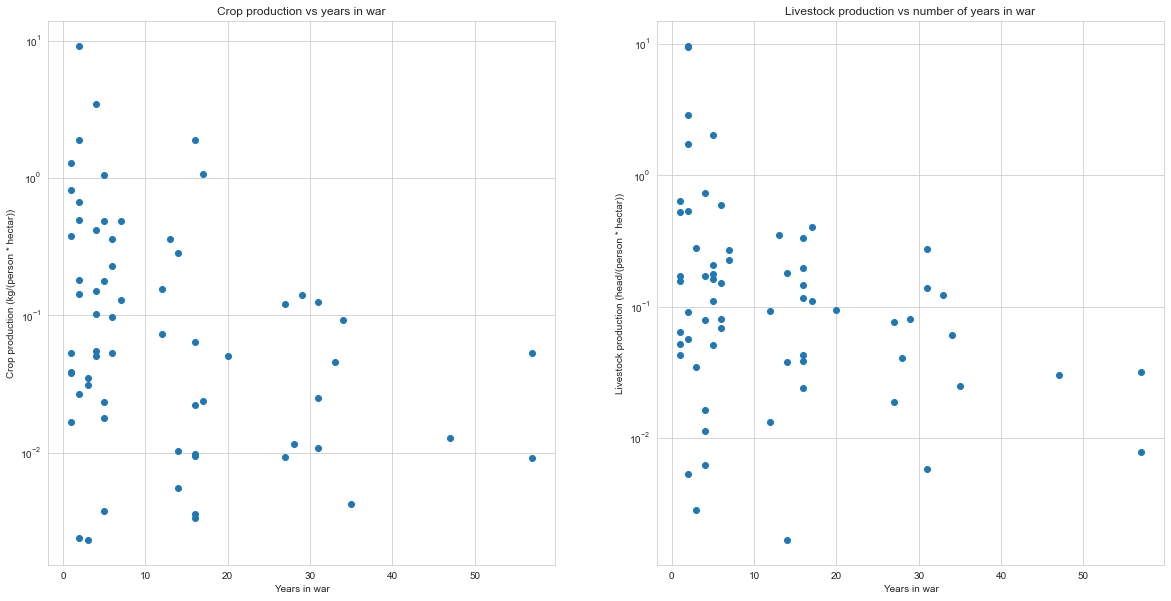

In [457]:
years_in_war = avg_production_years_in_war['years']
mean_crops = avg_production_years_in_war['norm_value_crop']
mean_livestock = avg_production_years_in_war['norm_value_livestock']

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(years_in_war, mean_crops, marker='o', linestyle='None')
ax[0].set_title('Crop production vs years in war')
ax[0].set_ylabel('Crop production (kg/(person * hectar))')
ax[0].set_xlabel('Years in war')
ax[0].set_yscale('log')

# for i, txt in enumerate(avg_production_years_in_war['country']):
#    ax[0].annotate(txt, (years_in_war[i], mean_crops[i]))

ax[1].plot(years_in_war, mean_livestock, marker='o', linestyle='None')
ax[1].set_title('Livestock production vs number of years in war')
ax[1].set_ylabel('Livestock production (head/(person * hectar))')
ax[1].set_xlabel('Years in war')
_ = ax[1].set_yscale('log')

In [495]:
# Import DFs of years_in_war and country_centroids for continent data

# Set folder name
file_path = '../pandas_dfs/'

# Set filenames
years_in_war_file = 'years_per_country.csv'
centroids_file = 'country_centroids.csv'

# Read the files
years_per_country = pd.read_csv(file_path + years_in_war_file, encoding='latin-1')
centroids_df = pd.read_csv(file_path + centroids_file, encoding='latin-1')

In [496]:
centroids_df = centroids_df[['sovereignt', 'continent', 'homepart']]
centroids_df = centroids_df.loc[centroids_df['homepart'] == 1]
centroids_df.drop(['homepart'], axis=1,inplace=True)
centroids_df = centroids_df.rename(columns={'sovereignt': 'country'})

centroids_df.head()

,country,continent
1,Afghanistan,Asia
2,Angola,Africa
4,Albania,Europe
6,Andorra,Europe
7,United Arab Emirates,Asia


In [497]:
years_per_country.head()

,country,years
0,Mali,1
1,South Ossetia,1
2,South Korea,1
3,Slovenia,1
4,Burkina Faso,1


In [498]:
# Used this cell to look at different countr names in both dfs

temp = merged_crops_data.loc[merged_crops_data['country'].str.contains('Slovenia')]
temp2 = wars_df.loc[wars_df['country'].str.contains('Slovenia')]
temp3 = centroids_df.loc[centroids_df['country'].str.contains('China')]
temp3

,country,continent
41,China,Asia


In [499]:
# Created copies of DFs for now to not risk messing up the plots above

wars_rate_df = wars_df.copy()
merged_crops_rate_data = merged_crops_data.copy()

In [500]:
# Rename country names that do not match between dfs and remove ones that we don't need

wars_rate_df['country'].replace(
    {"People's Republic of China" : "China",
    'Democratic Republic of the Congo' : 'Congo',
    'Republic of the Congo' : 'Congo',
    'State of Palestine' : 'Palestine',
    'South Sudan' : 'Sudan'}, 
    inplace = True)

merged_crops_rate_data['country'].replace(
    {'Iran (Islamic Republic of)' : 'Iran',
    'Republic of Moldova' : 'Moldova',
    'Republic of Korea' : 'South Korea',
    'Bolivia (Plurinational State of)' : 'Bolivia',
    'Ethiopia PDR' : 'Ethiopia',
    'Timor-Leste' : 'East Timor',
    'South Sudan' : 'Sudan'}, 
    inplace = True)
years_per_country['country'].replace(
    {'Iran (Islamic Republic of)' : 'Iran',
    'Republic of Moldova' : 'Moldova',
    'Republic of Korea' : 'South Korea',
    'Bolivia (Plurinational State of)' : 'Bolivia',
    'Ethiopia PDR' : 'Ethiopia',
    'Timor-Leste' : 'East Timor',
    'South Sudan' : 'Sudan'}, 
    inplace = True)

centroids_df['country'].replace(
    {"People's Republic of China" : "China",
    'Democratic Republic of the Congo' : 'Congo',
    'Republic of the Congo' : 'Congo',
    'State of Palestine' : 'Palestine',
    'South Sudan' : 'Sudan'}, 
    inplace = True)

# South Sudan became independent in 2011, but all wars in Sudan started before then. Therefore, I changed South Sudan to Sudan.

# Rows to potentially remove from war_df for this analysis:

# Myanmar and Angola are in war for the entire duration of our crop data, should we simply remove them from our analysis?
# We have no crop data for: Artsakh, South Ossetia, Rhodesia, Abkhazia
# No data for years where Slovenia is in war

wars_rate_df = wars_rate_df[wars_rate_df['country'] != 'Myanmar']
wars_rate_df = wars_rate_df[wars_rate_df['country'] != 'Angola']
wars_rate_df = wars_rate_df[wars_rate_df['country'] != 'Artsakh']
wars_rate_df = wars_rate_df[wars_rate_df['country'] != 'South Ossetia']
wars_rate_df = wars_rate_df[wars_rate_df['country'] != 'Rhodesia']
wars_rate_df = wars_rate_df[wars_rate_df['country'] != 'Republic of Abkhazia']
wars_rate_df = wars_rate_df[wars_rate_df['country'] != 'Kosovo']
wars_rate_df = wars_rate_df[wars_rate_df['country'] != 'Slovenia']

In [501]:
wars_rate_df = pd.merge(wars_rate_df, centroids_df, left_on='country', right_on='country')
wars_rate_df = pd.merge(wars_rate_df, years_per_country, left_on='country', right_on='country')

In [502]:
wars_rate_df.head()

,name,country,end_year,is_state,location,participant,start_year,continent,years
0,Indo-Pakistani War of 1965.,Pakistan,1965-01-01,True,Kashmir,India,1965-01-01,Asia,16
1,Indo-Pakistani War of 1965.,Pakistan,1965-01-01,True,Kashmir,Pakistan,1965-01-01,Asia,16
2,War in North-West Pakistan,Pakistan,2017-01-01,True,Federally Administered Tribal Areas,United States of America,2004-01-01,Asia,16
3,War in North-West Pakistan,Pakistan,2017-01-01,True,Federally Administered Tribal Areas,Islamic State of Iraq and the Levant,2004-01-01,Asia,16
4,War in North-West Pakistan,Pakistan,2017-01-01,True,Federally Administered Tribal Areas,Pakistan,2004-01-01,Asia,16


In [314]:
afghanistan_crops = (
    merged_crops_rate_data[merged_crops_rate_data['country'] == 'China']
        .drop(['norm_value_crop', 'norm_value_livestock', 'value_population', 'value_land_area', 'value_livestock'], axis=1)
        .reset_index(drop=True)
)

afghanistan_in_war = country_in_war(wars_rate_df, afghanistan_crops, 'China')

first_row = pd.DataFrame({'in_war': False, 'value_crop': 0, 'year': np.NaN}, index=[0])

afghanistan_shifted = (
    pd.concat([first_row, afghanistan_in_war[:]], sort=False).reset_index(drop=True)
        .drop(['year'], axis=1)[:-1]
        .rename(columns={'value_crop': 'previous_crop'})
)

rated_crops = pd.concat([afghanistan_shifted, afghanistan_crops], axis=1)[1:].reset_index(drop=True)

rated_crops['rate'] = rated_crops.apply(lambda row: row['value_crop'] - row['previous_crop'], axis=1)

grouped_rated_crops = rated_crops.groupby('in_war').mean().reset_index()

rate_in_war = grouped_rated_crops.loc[grouped_rated_crops['in_war'] == True, 'rate'].to_numpy()
rate_not_in_war = grouped_rated_crops.loc[grouped_rated_crops['in_war'] == False, 'rate'].to_numpy()

rate_in_war[0], rate_not_in_war[0]

(37066592.0, 28718596.98181818)

In [488]:
def compute_rate(wars_df, country, agricultural_data):
    
    try:
        country_crops = (
            agricultural_data[agricultural_data['country'] == country]
                .drop(['norm_value_crop', 'norm_value_livestock', 'value_population', 'value_land_area', 'value_livestock'], axis=1)
                .reset_index(drop=True)
        )

        years_in_war = country_in_war(wars_df, country_crops, country)

        first_row = pd.DataFrame({'in_war': False, 'value_crop': 0, 'year': np.NaN}, index=[0])

        country_shifted = (
            pd.concat([first_row, years_in_war[:]], sort=False).reset_index(drop=True)
                .drop(['year'], axis=1)[:-1]
                .rename(columns={'value_crop': 'previous_crop'})
        )

        rated_crops = pd.concat([country_shifted, country_crops], axis=1)[1:].reset_index(drop=True)

        rated_crops['rate'] = rated_crops.apply(lambda row: (row['value_crop'] - row['previous_crop'])/row['previous_crop']*100, axis=1)

        grouped_rated_crops = rated_crops.groupby('in_war').mean().reset_index()

        rate_in_war = grouped_rated_crops.loc[grouped_rated_crops['in_war'] == True, 'rate'].to_numpy()
        rate_not_in_war = grouped_rated_crops.loc[grouped_rated_crops['in_war'] == False, 'rate'].to_numpy()

        return rate_in_war[0], rate_not_in_war[0]
    except:
        print(country)

In [521]:
# Test the function...
compute_rate(wars_rate_df, 'Sudan', merged_crops_data)

(7.5378731234699154, 3.732619718933191)

In [504]:
wars_rate_df['rate-change'] = wars_rate_df.apply(lambda x: compute_rate(wars_rate_df, x['country'], merged_crops_rate_data), axis=1)

In [515]:
# Sudan's war rate is doubled for some reason here, while when you run it once (above cell) it is not O_o
# this is probably the case for other countries as well, hence why the plot looks the way it does...

wars_rate_df.loc[wars_rate_df['country'] == 'Sudan']

,name,country,end_year,is_state,location,participant,start_year,continent,years,rate-war,rate-no-war
362,Darfur conflict,Sudan,2017-01-01,True,Darfur,Sudan,2003-01-01,Africa,31,15.949665,3.73262
363,Darfur conflict,Sudan,2017-01-01,True,Darfur,Sudan,2003-01-01,Africa,35,15.949665,3.73262
364,Darfur conflict,Sudan,2017-01-01,True,Darfur,Sudan,2003-01-01,Africa,31,15.949665,3.73262
365,Darfur conflict,Sudan,2017-01-01,True,Darfur,Sudan,2003-01-01,Africa,35,15.949665,3.73262
366,Second Sudanese Civil War,Sudan,2005-01-01,True,Blue Nile,Sudan,1983-01-01,Africa,31,15.949665,3.73262
367,Second Sudanese Civil War,Sudan,2005-01-01,True,Blue Nile,Sudan,1983-01-01,Africa,35,15.949665,3.73262
368,Second Sudanese Civil War,Sudan,2005-01-01,True,Blue Nile,Sudan,1983-01-01,Africa,31,15.949665,3.73262
369,Second Sudanese Civil War,Sudan,2005-01-01,True,Blue Nile,Sudan,1983-01-01,Africa,35,15.949665,3.73262
370,Second Sudanese Civil War,Sudan,2005-01-01,True,Blue Nile,Uganda,1983-01-01,Africa,31,15.949665,3.73262
371,Second Sudanese Civil War,Sudan,2005-01-01,True,Blue Nile,Uganda,1983-01-01,Africa,35,15.949665,3.73262


In [511]:
# Split rates column into 2 separate columns and drop the rate-change column

wars_rate_df[['rate-war', 'rate-no-war']] = pd.DataFrame(wars_rate_df['rate-change'].tolist(), index = wars_rate_df.index)

wars_rate_df.drop(['rate-change'], axis = 1, inplace = True)

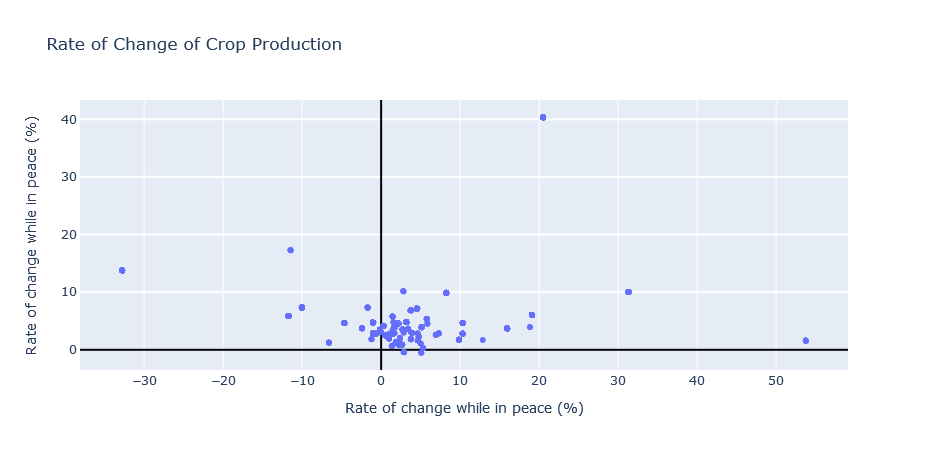

In [519]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(
    x=wars_rate_df['rate-war'], 
    y=wars_rate_df['rate-no-war'],
    hovertext=wars_rate_df['country'],
    mode='markers',
    marker=dict(colorscale='Blues')
))

fig.update_layout(
    title_text = 'Rate of Change of Crop Production',
    showlegend = False,
    xaxis = go.layout.XAxis(
        side = 'bottom',
        type = 'linear',
        title = 'Rate of change while in peace (%)',
        mirror =  True,
        showline = True,
        gridcolor = 'rgb(255, 255, 255)',
        gridwidth = 1,
        fixedrange = True,
        zerolinewidth = 1),
    yaxis = go.layout.YAxis(
        type = 'linear',
        title = 'Rate of change while in peace (%)',
        mirror =  True,
        showline = True,
        gridcolor = 'rgb(255, 255, 255)',
        gridwidth = 2,
        fixedrange = True,
        zerolinewidth = 1),
    
)

fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black')

fig.show()

In [ ]:
xaxis = go.layout.XAxis(
        tickangle = 90,
        title_text = "Month",
        title_font = {"size": 20},
        title_standoff = 25),
    yaxis = go.layout.YAxis(
        title_text = "Temperature",
        title_standoff = 25))
"xaxis": {
      "side": "bottom",
      "type": "linear",
      "range": [
        -3.5,
        3.5
      ],
      "title": "Spawn Rate",
      "mirror": true,
      "ticklen": 5,
      "showline": true,
      "autorange": false,
      "gridcolor": "rgb(255, 255, 255)",
      "gridwidth": 1,
      "fixedrange": true,
      "zerolinewidth": 1
    },
    "yaxis": {
      "type": "linear",
      "range": [
        -3.5,
        3.5
      ],
      "title": "Catch/Flee Ratio",
      "ticklen": 5,
      "autorange": false,
      "gridcolor": "rgb(255, 255, 255)",
      "gridwidth": 2,
      "fixedrange": true,
      "zerolinewidth": 1
    },
